In [11]:
import numpy as np
import pandas as pd
import sys
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
sys.path.insert(0, 'C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions')
import MEG_pareidolia_utils
from MEG_pareidolia_utils import *
# import df_ALL_metadata_MEG_sub00to11_epo_RT_sham.csv

df = pd.read_csv('df_ALL_metadata_MEG_sub00to11_epo_long_sham.csv')
DAT_df = pd.read_csv('../questionnaire_data_perso/DAT_MEG.csv')
from statsmodels.stats.multitest import fdrcorrection


epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', '1', stage = 'epo_long', cond=None)
epochs = mne.read_epochs(epochs_path)
info = epochs.pick_types(meg=True, ref_meg=False).info

C:\Users\Antoine\AppData\Local\Temp\ipykernel_5584\3386539134.py:16: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...
    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('df_ALL_metadata_MEG_sub00to11_epo_RT_RT_newbands.csv')

In [20]:
df.columns

Index(['electrodes', 'delta', 'theta', 'alpha', 'low_beta', 'high_beta',
       'gamma1', 'gamma2', 'trials', 'bloc', 'participant', 'FD', 'FD_class',
       'n_obj', 'n_obj_class', 'parei', 'contrast', 'earlyVSlate', 'LZ',
       'Unnamed: 0', 'offset', 'exp', 'freq_range', 'freq_res', 'DAT'],
      dtype='object')

## Single Features on RT

In [263]:
import xgboost

In [14]:
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_predict, GridSearchCV, RandomizedSearchCV, permutation_test_score
from sklearn.metrics import balanced_accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Assuming df is your DataFrame
# Your data preparation steps...

# Define your columns, electrodes, groups, etc.
freq_cols = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'LZ']
electrodes = df['electrodes'].unique()
groups = df['participant']

# Initialize a dictionary to store the results for each electrode and feature
results = {electrode: {feature: {} for feature in freq_cols} for electrode in electrodes}

# standardize data within participant
for participant in df['participant'].unique():
    df.loc[df['participant'] == participant, freq_cols] = StandardScaler().fit_transform(df.loc[df['participant'] == participant, freq_cols])

# Define your parameter grid or distributions
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 6, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Define hyperparameters for Randomized Search (or Grid Search)
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 6, 10, 20, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
y = df['parei']
param_distribution_xgboost = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 6, 10, 20, None],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, (sum(y==0) / sum(y==1)), 10]  # Adjust for imbalanced classes
}
use_randomized_search = True
n_iter_search = 20
n_permutations = 100
n_splits = len(df['participant'].unique())
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)

imputer = SimpleImputer(strategy='mean')
print('HELLO')
# Loop over each electrode and feature
for electrode in electrodes:
    for feature in freq_cols:
        sub_df = df[df['electrodes'] == electrode]
        X = sub_df[[feature]]
        y = sub_df['parei']
        groups = sub_df['participant']

        # Impute missing values in X
        X_imputed = imputer.fit_transform(X)

        '''# Initialize the classifier with Grid Search or Randomized Search
        if use_randomized_search:
            search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                           param_distributions, n_iter=n_iter_search, cv=sgkf, scoring='balanced_accuracy')
        else:
            search_cv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                     param_grid, cv=sgkf, scoring='balanced_accuracy')
'''
        search_cv = RandomizedSearchCV(
                                xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
                                param_distribution_xgboost,
                                n_iter=n_iter_search,
                                scoring='balanced_accuracy',
                                cv=sgkf,
                                random_state=42,
                                n_jobs=-1
                            )
        
        # Fit the model
        search_cv.fit(X_imputed, y, groups=groups)

        # Best estimator
        best_clf = search_cv.best_estimator_

        # Permutation Test Score
        score, permutation_scores, pvalue = permutation_test_score(
            best_clf, X_imputed, y, scoring="balanced_accuracy", cv=sgkf, n_permutations=n_permutations, groups=groups, n_jobs=-1)

        # Make predictions and calculate additional metrics
        #predictions = cross_val_predict(best_clf, X_imputed, y, cv=sgkf, groups=groups, n_jobs=-1)
        #f1 = f1_score(y, predictions)
        #roc_auc = roc_auc_score(y, best_clf.predict_proba(X_imputed)[:, 1])

        # Store results for the current electrode and feature
        results[electrode][feature] = {
            'balanced_accuracy': score,
            'best_params': search_cv.best_params_,
            'p_value': pvalue
        }

        print(f"Electrode {electrode}, Feature {feature}: ROC = {search_cv.best_score_:.4f}, Best Params: {search_cv.best_params_}")
        print(f"Electrode {electrode}, Feature {feature}: Permutation Test Score = {score:.4f}, p-value = {pvalue:.4f}")
# save results
import pickle
with open('results_RT_single_feature_xgboost_standardized_bACC.pkl', 'wb') as f:
    pickle.dump(results, f)
# After the loop, you can inspect the 'results' dictionary for detailed outcomes


HELLO
Electrode 0, Feature delta: F1 = 0.8380)
Electrode 0, Feature delta: Permutation Test Score = 0.8380, p-value = 1.0000
Electrode 0, Feature theta: F1 = 0.8380)
Electrode 0, Feature theta: Permutation Test Score = 0.8380, p-value = 1.0000
Electrode 0, Feature alpha: F1 = 0.8380)
Electrode 0, Feature alpha: Permutation Test Score = 0.8380, p-value = 1.0000
Electrode 0, Feature low_beta: F1 = 0.8380)
Electrode 0, Feature low_beta: Permutation Test Score = 0.8380, p-value = 1.0000
Electrode 0, Feature high_beta: F1 = 0.8380)
Electrode 0, Feature high_beta: Permutation Test Score = 0.8380, p-value = 1.0000
Electrode 0, Feature gamma1: F1 = 0.8380)
Electrode 0, Feature gamma1: Permutation Test Score = 0.8380, p-value = 0.9901
Electrode 0, Feature gamma2: F1 = 0.8380)
Electrode 0, Feature gamma2: Permutation Test Score = 0.8380, p-value = 0.9901
Electrode 0, Feature LZ: F1 = 0.8380)
Electrode 0, Feature LZ: Permutation Test Score = 0.8380, p-value = 0.9505
Electrode 0, Feature exp: F1 =

KeyboardInterrupt: 

## Maximum tests for short epochs

In [5]:
import pandas as pd
import numpy as np
import xgboost
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV, permutation_test_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import pickle

# Assuming df is your DataFrame
# Your data preparation steps...

# Define your columns, electrodes, groups, etc.
freq_cols = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'gamma3', 'LZ']
electrodes = df['electrodes'].unique()
groups = df['participant']

# Initialize a dictionary to store the results for each electrode and feature
results = {electrode: {feature: {} for feature in freq_cols} for electrode in electrodes}

# Standardize data within participant
for participant in df['participant'].unique():
    df.loc[df['participant'] == participant, freq_cols] = StandardScaler().fit_transform(df.loc[df['participant'] == participant, freq_cols])

# Define hyperparameters for Randomized Search
param_distribution_xgboost = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 6, 10, 20, None],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.5, 0.75, 1.0],
    'colsample_bytree': [0.5, 0.75, 1.0],
    'gamma': [0, 1, 5],
    'scale_pos_weight': [1, (sum(df['parei']==0) / sum(df['parei']==1)), 10]  # Adjust for imbalanced classes
}

n_iter_search = 20
n_permutations = 1000
n_splits = len(df['participant'].unique())
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False)

imputer = SimpleImputer(strategy='mean')
print('HELLO')
all_permutation_scores = []
# Loop over each electrode and feature
for electrode in electrodes:
    for feature in freq_cols:
        sub_df = df[df['electrodes'] == electrode]
        X = sub_df[[feature]]
        y = sub_df['parei']
        groups = sub_df['participant']

        # Impute missing values in X
        X_imputed = imputer.fit_transform(X)

        search_cv = RandomizedSearchCV(
            xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42),
            param_distribution_xgboost,
            n_iter=n_iter_search,
            scoring='balanced_accuracy',
            cv=sgkf,
            random_state=42,
            n_jobs=-1
        )

        # Fit the model
        search_cv.fit(X_imputed, y, groups=groups)

        # Best estimator
        best_clf = search_cv.best_estimator_

        # Permutation Test Score
        score, permutation_scores, pvalue = permutation_test_score(
            best_clf, X_imputed, y, scoring="balanced_accuracy", cv=sgkf, n_permutations=n_permutations, groups=groups, n_jobs=-1)
        all_permutation_scores.append(permutation_scores)
        # Store results for the current electrode and feature
        results[electrode][feature] = {
            'balanced_accuracy': score,
            'best_params': search_cv.best_params_,
            'p_value': pvalue,
            'permutation_scores': permutation_scores
        }

        print(f"Electrode {electrode}, Feature {feature}: Balanced Accuracy = {score:.4f}, p-value = {pvalue:.4f}, Best Params: {search_cv.best_params_}")



# Save results
with open('results_RT_single_feature_xgboost_standardized_bACC_test_maxstat.pkl', 'wb') as f:
    pickle.dump(results, f)

# Aggregating permutation scores
max_permutation_scores = np.max(all_permutation_scores, axis=0)

# Calculating adjusted p-values
for electrode in electrodes[0:2]:
    for feature in freq_cols[0:2]:
        observed_score = results[electrode][feature]['balanced_accuracy']
        adjusted_p_value = np.mean(max_permutation_scores >= observed_score)
        results[electrode][feature]['adjusted_p_value'] = adjusted_p_value
        print(f"Electrode {electrode}, Feature {feature}: Adjusted p-value = {adjusted_p_value:.4f}")

# Save the updated results
with open('adjusted_results.pkl', 'wb') as f:
    pickle.dump(results, f)


HELLO
Electrode 0, Feature delta: Balanced Accuracy = 0.5215, p-value = 0.0959, Best Params: {'subsample': 0.5, 'scale_pos_weight': 0.32463768115942027, 'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.75}
Electrode 0, Feature theta: Balanced Accuracy = 0.5253, p-value = 0.0669, Best Params: {'subsample': 0.5, 'scale_pos_weight': 0.32463768115942027, 'n_estimators': 50, 'max_depth': 20, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 0.75}
Electrode 0, Feature alpha: Balanced Accuracy = 0.5334, p-value = 0.0210, Best Params: {'subsample': 0.75, 'scale_pos_weight': 0.32463768115942027, 'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.5}
Electrode 0, Feature low_beta: Balanced Accuracy = 0.5179, p-value = 0.1209, Best Params: {'subsample': 0.75, 'scale_pos_weight': 0.32463768115942027, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.5}
Electrode 0,

In [22]:
# Aggregating permutation scores
max_permutations_scores = np.max(np.column_stack(all_permutation_scores), axis=0)

# Calculating adjusted p-values
for electrode in electrodes[:]:
    for feature in freq_cols[:]:
        observed_score = results[electrode][feature]['balanced_accuracy']
        adjusted_p_value = np.mean(max_permutation_scores >= observed_score)
        results[electrode][feature]['adjusted_p_value'] = adjusted_p_value
        print(f"Electrode {electrode}, Feature {feature}: Adjusted p-value = {adjusted_p_value:.4f}")

# Save the updated results
with open('adjusted_results_XGBoost.pkl', 'wb') as f:
    pickle.dump(results, f)

Electrode 0, Feature delta: Adjusted p-value = 1.0000
Electrode 0, Feature theta: Adjusted p-value = 1.0000
Electrode 0, Feature alpha: Adjusted p-value = 1.0000
Electrode 0, Feature low_beta: Adjusted p-value = 1.0000
Electrode 0, Feature high_beta: Adjusted p-value = 1.0000
Electrode 0, Feature gamma1: Adjusted p-value = 1.0000
Electrode 0, Feature gamma2: Adjusted p-value = 1.0000
Electrode 0, Feature gamma3: Adjusted p-value = 1.0000
Electrode 0, Feature LZ: Adjusted p-value = 1.0000
Electrode 1, Feature delta: Adjusted p-value = 1.0000
Electrode 1, Feature theta: Adjusted p-value = 1.0000
Electrode 1, Feature alpha: Adjusted p-value = 1.0000
Electrode 1, Feature low_beta: Adjusted p-value = 1.0000
Electrode 1, Feature high_beta: Adjusted p-value = 1.0000
Electrode 1, Feature gamma1: Adjusted p-value = 0.0700
Electrode 1, Feature gamma2: Adjusted p-value = 1.0000
Electrode 1, Feature gamma3: Adjusted p-value = 1.0000
Electrode 1, Feature LZ: Adjusted p-value = 1.0000
Electrode 2, F

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  1.,  0.,  2.,
         3.,  3.,  1.,  6.,  4.,  5.,  6., 10., 13., 10., 12., 18., 18.,
        24., 17., 29., 29., 25., 21., 23., 29., 24., 29., 35., 21., 28.,
        33., 28., 25., 29., 28., 25., 17., 19., 27., 26., 27., 23., 17.,
        14., 15., 15., 16.,  9., 15.,  6., 12.,  8.,  7.,  9., 11.,  7.,
         8.,  7.,  6.,  5.,  3.,  5.,  2.,  6.,  5.,  3.,  5.,  0.,  3.,
         2.,  0.,  2.,  5.,  1.,  1.,  1.,  1.,  2.,  0.,  1.,  1.,  0.,
         0.,  1.,  1.,  1.,  0.,  0.,  2.,  0.,  2.]),
 array([0.53831823, 0.53866892, 0.5390196 , 0.53937028, 0.53972097,
        0.54007165, 0.54042234, 0.54077302, 0.54112371, 0.54147439,
        0.54182507, 0.54217576, 0.54252644, 0.54287713, 0.54322781,
        0.5435785 , 0.54392918, 0.54427987, 0.54463055, 0.54498123,
        0.54533192, 0.5456826 , 0.54603329, 0.54638397, 0.54673466,
        0.54708534, 0.54743602, 0.54778671, 0.54813739, 0.54848808,
        0.54883876, 0.5491

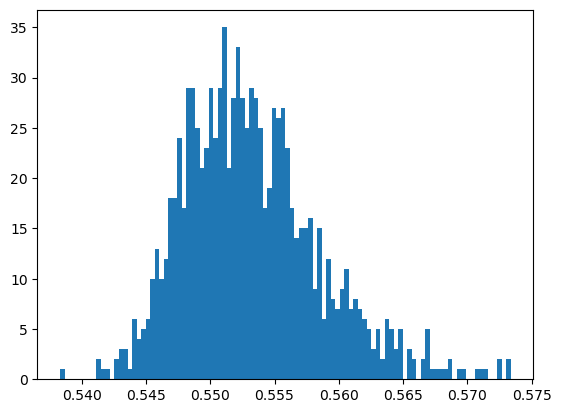

In [21]:
# plot distribution of all permutation scores
import matplotlib.pyplot as plt
plt.hist(max_permutation_scores, bins=100)

In [301]:
import numpy as np
import matplotlib.pyplot as plt
import mne

def topoplot_array(
    toplot_list,
    ch_xy,
    titles=None,
    savefig=True,
    figpath="topoplot.png",
    vmin=None,
    vmax=None,
    cmap="viridis",
    mask_all=None,
):
    # Determine the number of rows and columns for the subplot grid
    n_topoplots = len(toplot_list)
    #n_cols = int(np.ceil(np.sqrt(n_topoplots)))
    #n_rows = int(np.ceil(n_topoplots / n_cols))
    n_cols = n_topoplots
    n_rows = 1
    # Create a figure with subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

    for i, (ax, toplot, mask) in enumerate(zip(axs.flat, toplot_list, mask_all)):
        # Compute vmin and vmax if not specified
        if vmin is None:
            vmin = np.min(toplot)
        if vmax is None:
            vmax = np.max(toplot)

        # Plot topomap
        image, _ = mne.viz.plot_topomap(
            data=toplot,
            pos=ch_xy,
            cmap=cmap,
            vlim=[vmin, vmax],
            outlines="head",
            sphere=0.19,
            mask=mask,
            axes=ax,
            show=False,
            contours=0,
            mask_params=dict(markersize=10, markerfacecolor="w", markeredgecolor="k", linewidth=0.1, alpha=0.8),
        )

        # Set title if specified
        if titles is not None:
            ax.set_title(titles[i], fontdict={"fontsize": 10, "fontweight": "heavy"})

    # Adjust layout
    plt.tight_layout()

    # Add a colorbar
    fig.colorbar(image, ax=axs.ravel().tolist(), shrink=0.95)

    # Save plot if specified
    if savefig:
        plt.savefig(figpath, dpi=300)

    return fig


[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    0.999 1.    1.    1.    1.    1.
 1.    1.    1.    0.999 1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    0.969 1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.986 0.993 0.937
 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
 1.    1.    1.  

'topoplot_array(\n    all_balanced_accuracy,\n    info,\n    titles=features,\n    savefig=True,\n    figpath=f"{foldername}/topoplot_{metric}.png",\n    vmin=0.5,\n    vmax=0.56,\n    mask_all=all_mask,\n    cmap="viridis",\n)'

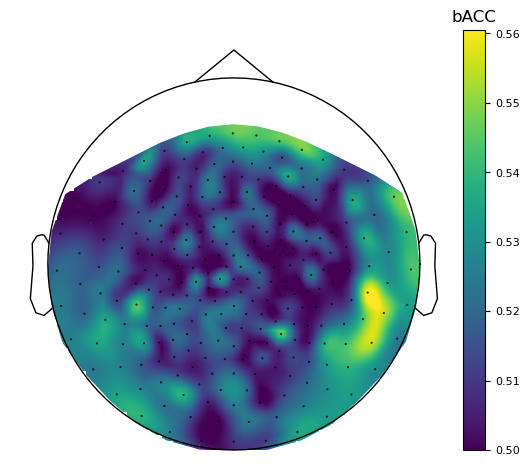

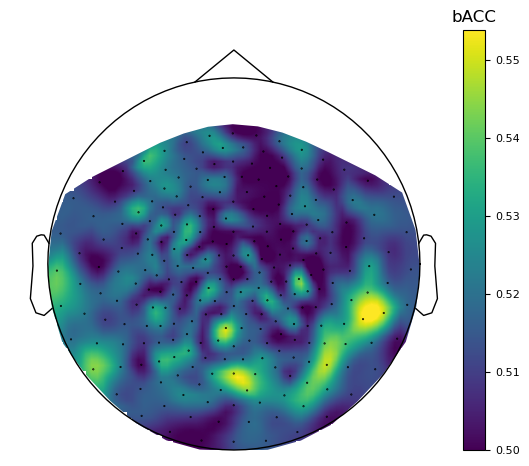

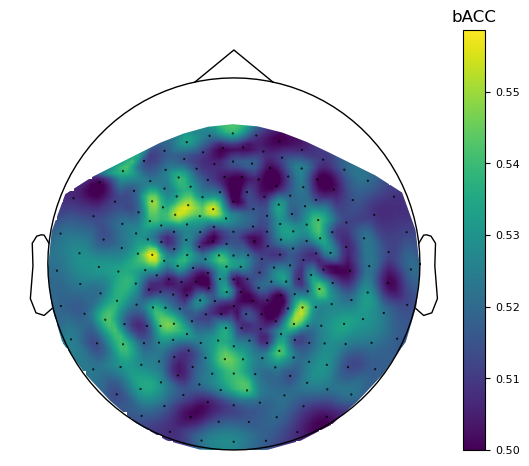

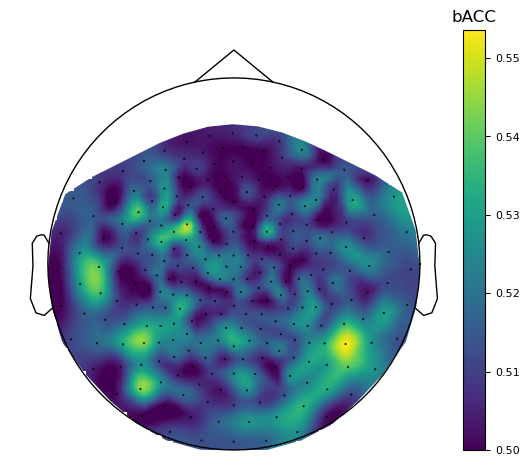

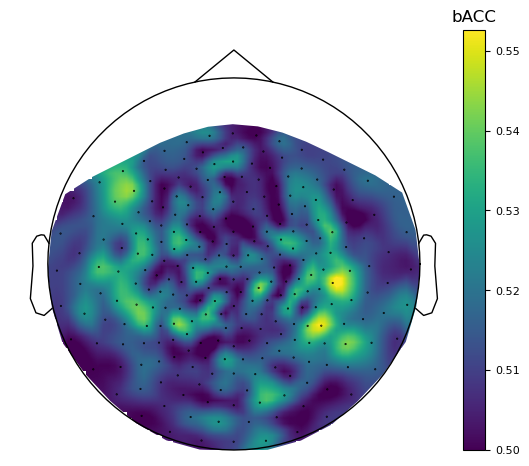

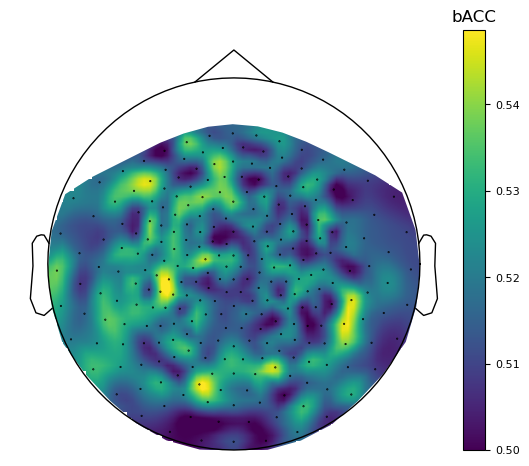

In [20]:
import os
import pickle
#results = pickle.load(open('results_RT_single_feature_xgboost2.pkl', 'rb'))
results_df = pd.DataFrame.from_dict({(i,j): results[i][j]
                            for i in results.keys()
                            for j in results[i].keys()},
                          orient='index')


foldername = 'stratified_leave_one_group_xgboost_maxstat_bACC'
#os.mkdir(foldername)
features = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'gamma3', 'LZ']
metric = 'balanced_accuracy'

all_balanced_accuracy = []
all_mask = []
# get balanced accuracy for all electrodes
for feature in features:
  balanced_accuracy = results_df.loc[(slice(None), feature), metric].values
  # get p-values for all electrodes
  p_values = results_df.loc[(slice(None), feature), 'adjusted_p_value'].values

  balanced_accuracy = np.array(balanced_accuracy)
  # create mask for p-values
  p_values = np.array(p_values)
  print(p_values)
  p_values_mask = p_values < 0.05
  # create mask for feature importance
  all_mask.append(p_values_mask)
  all_balanced_accuracy.append(balanced_accuracy)
  topoplot(
      balanced_accuracy,
      info,
      titles=features,
      savefig=True,
      figpath=f"{foldername}/topoplot_adjusted_{metric}_{feature}.png",
      vmin=0.5,
      vmax=np.max(balanced_accuracy),
      mask=p_values_mask,
      cmap="viridis",
      ax_title='bACC',
  )

# use topoplot_array function to plot all electrodes
'''topoplot_array(
    all_balanced_accuracy,
    info,
    titles=features,
    savefig=True,
    figpath=f"{foldername}/topoplot_{metric}.png",
    vmin=0.5,
    vmax=0.56,
    mask_all=all_mask,
    cmap="viridis",
)'''

In [270]:
results_df

balanced_accuracy  f1_score  roc_auc_score  \
0   delta               0.518873  0.539753       0.623657   
    theta               0.523423  0.529884       0.634012   
    alpha               0.500000  0.860349       0.667315   
    low_beta            0.500000  0.860349       0.667198   
    high_beta           0.505282  0.672719       0.715369   
...                          ...       ...            ...   
269 gamma1              0.510587  0.463125       0.571701   
    gamma2              0.508610  0.565172       0.641288   
    LZ                  0.501302  0.444801       0.565653   
    exp                 0.514015  0.617100       0.669217   
    offset              0.512085  0.574632       0.577852   

                                                     best_params   p_value  
0   delta      {'subsample': 0.5, 'scale_pos_weight': 0.32463...  0.138614  
    theta      {'subsample': 0.5, 'scale_pos_weight': 0.32463...  0.079208  
    alpha      {'subsample': 1.0, 'scale_pos_weight': 10, 'n_...  1.000000  
    low_beta   {'subsample': 1.0, 'scale_pos_weight': 10, 'n_...  1.000000  
    high_beta  {'subsample': 1.0, 'scale_pos_weight': 0.32463...  0.237624  
...                                                          ...       ...  
269 gamma1     {'subsample': 1.0, 'scale_pos_weight': 0.32463...  0.069307  
    gamma2     {'subsample': 0.5, 'scale_pos_weight': 0.32463...  0.346535  
    LZ         {'subsample': 1.0, 'scale_pos_weight': 0.32463...  0.415842  
    exp        {'subsample': 0.75, 'scale_pos_weight': 0.3246...  0.306931  
    offset     {'subsample': 1.0, 'scale_pos_weight': 0.32463...  0.168317  

[2700 rows x 5 columns]

### One classifier per electrode

In [21]:
import pandas as pd

# Assuming df is your DataFrame and n_obj_class is the target variable
# participants are identified by the column 'participant'

# Group the data by participant and count the occurrences of each class in n_obj_class
class_distribution = df.groupby('participant')['parei'].value_counts(normalize=True).unstack(fill_value=0)

# Convert the class distribution to percentages
class_distribution_percentage = class_distribution * 100

# Print the class distribution for each participant
print(class_distribution_percentage)


parei                0          1
participant                      
0            16.923077  83.076923
1            22.435897  77.564103
2            25.641026  74.358974
3             2.884615  97.115385
4            66.885246  33.114754
5             5.177994  94.822006
6            69.230769  30.769231
7             6.089744  93.910256
8            14.423077  85.576923
9             1.602564  98.397436
10           21.794872  78.205128
11           41.958042  58.041958


In [152]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_predict, GridSearchCV, permutation_test_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

# Your frequency columns and data preparation remain the same
freq_cols = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'LZ',
             'FD']


# remove subjects 3 and 9
df = df[df['participant'] != 3]
df = df[df['participant'] != 9]

# keep rows when n_obj_class is not 0
#df = df[df['n_obj_class'] != 0]
# remove participant 5
#df = df[df['participant'] != 5]

# Standardize the data within each participant
# Standardize the data within each participant
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

for participant in df['participant'].unique():
    # Get the indices of the current participant
    participant_indices = df['participant'] == participant
    # Standardize the data and assign it back to the DataFrame
    df.loc[participant_indices, freq_cols] = scaler.fit_transform(df.loc[participant_indices, freq_cols])


electrodes = df['electrodes'].unique()
groups = df['participant']
# Initialize metrics
balanced_accuracies = []
f1_scores = []
roc_auc_scores = []
feature_importances = []
p_values = []

# Define hyperparameters for Grid Search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [2, 6, 10, 20],
    'criterion': ['gini', 'entropy']
}

# Define hyperparameters for Randomized Search (or Grid Search)
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 6, 10, 20, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose between GridSearchCV and RandomizedSearchCV
use_randomized_search = True
n_iter_search = 20  # Number of parameter settings sampled. Adjust as needed.


# Number of permutations
n_permutations = 100

# Group K-Fold for LOSO CV
#gkf = GroupKFold(n_splits=len(groups.unique()))

# Number of splits should match the number of unique participants
n_splits = len(df['participant'].unique())
print(f"Number of splits: {n_splits}")
# Stratified Group K-Fold for LOSO CV
sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False, random_state=None)
imputer = SimpleImputer(strategy='mean') 

for electrode in electrodes:
    sub_df = df[df['electrodes'] == electrode]
    X = sub_df[freq_cols]
    y = sub_df['parei']
    groups = sub_df['participant']

    # Impute missing values in X
    X_imputed = imputer.fit_transform(X)
    print(f"X_imputed shape: {X_imputed.shape}")
    # Rest of your code
    clf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=sgkf)
    clf.fit(X_imputed, y, groups=groups)
    # Best estimator
    best_clf = clf.best_estimator_

    # Initialize the classifier with Grid Search or Randomized Search
    if use_randomized_search:
        search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                       param_distributions, n_iter=n_iter_search, cv=sgkf, scoring='balanced_accuracy')
    else:
        search_cv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                 param_grid, cv=sgkf, scoring='balanced_accuracy')

    # Fit the model
    search_cv.fit(X_imputed, y, groups=groups)

    # Best estimator
    best_clf = search_cv.best_estimator_

    # Permutation Test Score
    score, permutation_scores, pvalue = permutation_test_score(
        best_clf, X_imputed, y, scoring="balanced_accuracy", cv=sgkf, n_permutations=n_permutations, groups=groups, n_jobs=-1)

    # Make predictions and calculate additional metrics
    predictions = cross_val_predict(best_clf, X_imputed, y, cv=sgkf, groups=groups, n_jobs=-1)
    f1 = f1_score(y, predictions)
    roc_auc = roc_auc_score(y, best_clf.predict_proba(X_imputed)[:, 1])

    # Store results
    balanced_accuracies.append(search_cv.best_score_)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    feature_importances.append(best_clf.feature_importances_)
    p_values.append(pvalue)
    print(f"Electrode {electrode}: Balanced Accuracy = {search_cv.best_score_:.4f}, F1 = {f1:.4f}, ROC-AUC = {roc_auc:.4f}, Best Params: {search_cv.best_params_}")
print(f"Balanced Accuracies: {balanced_accuracies}")
print(f"P-values: {p_values}")


Number of splits: 10
X_imputed shape: (3032, 9)
Electrode 0: Balanced Accuracy = 0.5087, F1 = 0.8018, ROC-AUC = 1.0000, Best Params: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'entropy'}
X_imputed shape: (3032, 9)
Electrode 1: Balanced Accuracy = 0.5166, F1 = 0.8107, ROC-AUC = 0.9989, Best Params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'gini'}
X_imputed shape: (3032, 9)
Electrode 2: Balanced Accuracy = 0.5165, F1 = 0.8127, ROC-AUC = 0.9992, Best Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}
X_imputed shape: (3032, 9)
Electrode 3: Balanced Accuracy = 0.5256, F1 = 0.8108, ROC-AUC = 1.0000, Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'entropy'}
X_imputed shape: (3032, 9)
Electrode 4: Balanced Accuracy = 0.5092, F1 = 0.8124, ROC-AUC = 

In [42]:
import pandas as pd

# Assuming df is your DataFrame and n_obj_class is the target variable
# participants are identified by the column 'participant'

# Group the data by participant and count the occurrences of each class in n_obj_class
class_distribution = df.groupby('participant')['n_obj_class'].value_counts(normalize=True).unstack(fill_value=0)

# Convert the class distribution to percentages
class_distribution_percentage = class_distribution * 100

# Print the class distribution for each participant
print(class_distribution_percentage)


n_obj_class          1          2
participant                      
0            46.783626  53.216374
1            50.000000  50.000000
2            48.898678  51.101322
3            16.501650  83.498350
4            76.237624  23.762376
5             2.054795  97.945205
6            80.208333  19.791667
7            31.399317  68.600683
8            75.280899  24.719101
9            16.286645  83.713355
10           44.672131  55.327869
11           77.397260  22.602740


In [156]:
# save all in a folder
# create a folder
import os
foldername = 'stratified_leave_one_group_random_forest_RT_results02'
os.mkdir(foldername)
import pickle
pickle.dump(balanced_accuracies, open(foldername + '/balanced_accuracies.pkl', 'wb'))
pickle.dump(f1_scores, open(foldername + '/f1_scores.pkl', 'wb'))
pickle.dump(roc_auc_scores, open(foldername + '/roc_auc_scores.pkl', 'wb'))
pickle.dump(feature_importances, open(foldername + '/feature_importances.pkl', 'wb'))
pickle.dump(p_values, open(foldername + '/p_values.pkl', 'wb'))

# save model

pickle.dump(best_clf, open(foldername + '/best_clf.pkl', 'wb'))

feature_names = X.columns
feature_importances_df = pd.DataFrame(feature_importances, columns=feature_names)
feature_importances_df.to_csv(foldername + '/feature_importances.csv')

In [28]:
len(balanced_accuracies)

227

In [32]:
# plot balanced accuracies in order to see which electrodes are the best

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=electrodes[0:227], y=balanced_accuracies, ax=ax)
ax.set_xlabel("Electrode")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy per Electrode")
plt.xticks(rotation=90)
plt.ylim(0.5, 0.6)
plt.tight_layout()
plt.show()


In [38]:
np.array(feature_importances).shape

(227, 16)

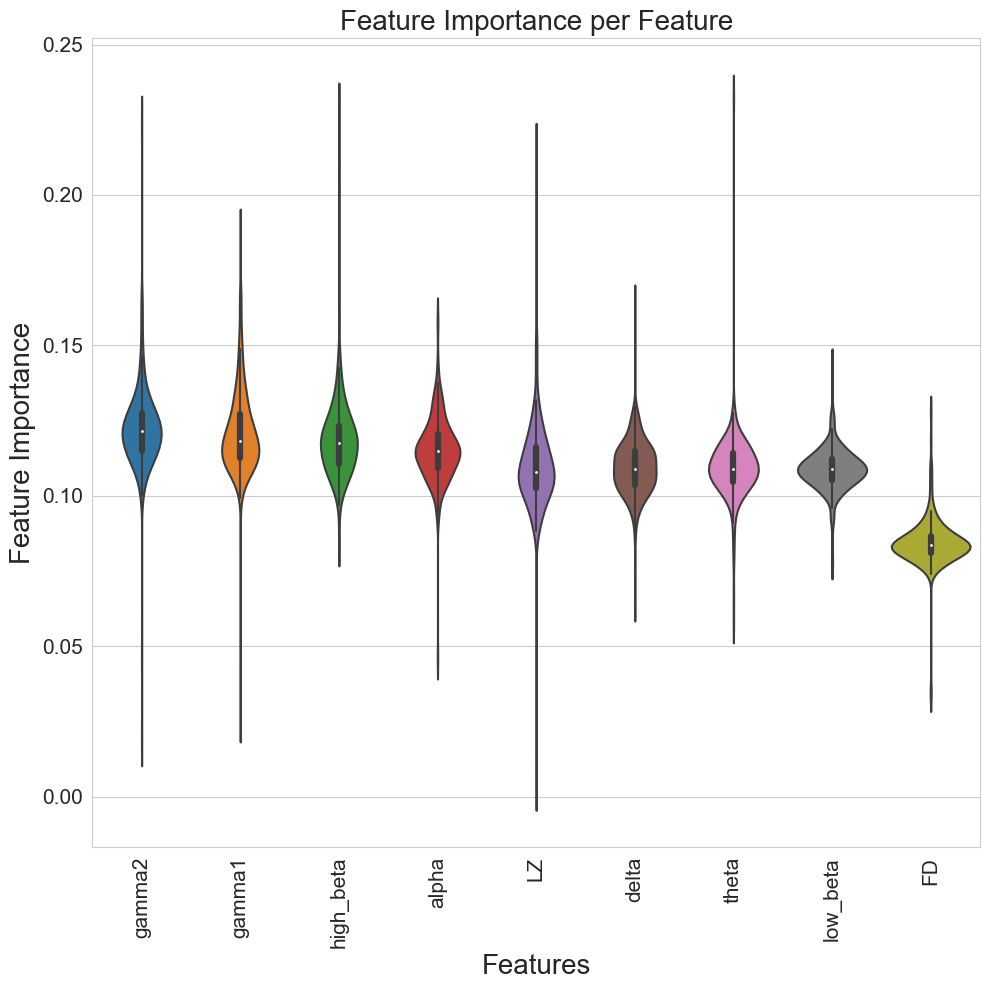

In [255]:
# plot feature importance
import matplotlib.pyplot as plt
# load feature importance
foldername = 'stratified_leave_one_group_random_forest_RT_results02'
feature_importances = pickle.load(open(foldername + '/feature_importances.pkl', 'rb'))

# Get feature names
feature_names = X.columns

# Get mean feature importance
mean_feature_importance = np.mean(feature_importances, axis=0)

# Sort feature importances in descending order
sorted_idx = np.argsort(mean_feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
# plot each feature as a violin plot

import seaborn as sns
sns.set_style('whitegrid')

# Plot
# remove Unnamed: 0
feature_importances_df = pd.DataFrame(feature_importances, columns=feature_names)
# order the dataframe by sorted_idx
feature_importances_df = feature_importances_df[feature_names[sorted_idx]]
fig, ax = plt.subplots(figsize=(10, 10))
sns.violinplot(data=feature_importances_df, ax=ax)
ax.set_xlabel("Features", fontsize=20)
ax.set_ylabel("Feature Importance", fontsize=20)
ax.set_title("Feature Importance per Feature", fontsize=20)
plt.xticks(rotation=90)
# tick labels size
plt.setp(ax.get_xticklabels(), fontsize=15)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.tight_layout()
plt.show()



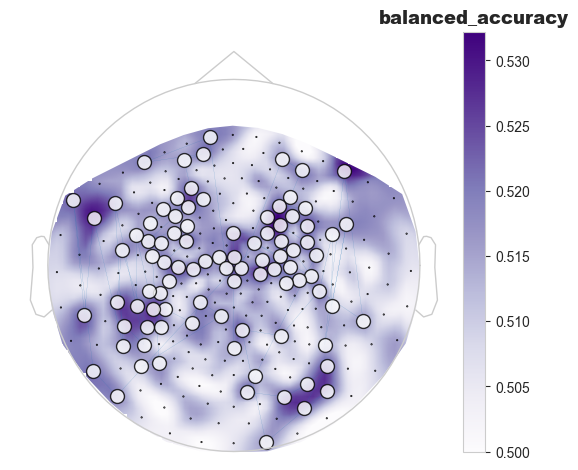

In [224]:
foldername = 'stratified_leave_one_group_random_forest_RT_results02'
# load balanced accuracies
balanced_accuracies = pickle.load(open(foldername + '/balanced_accuracies.pkl', 'rb'))
p_values = pickle.load(open(foldername + '/p_values.pkl', 'rb'))

reportpath = 'C:/Users/Antoine/github/MEG_pareidolia/Merged_dataframes/'
metric = balanced_accuracies
metric_name = 'balanced_accuracy'
# create mask for p-values
p_values = np.array(p_values)
p_values_mask = p_values < 0.01
# create mask for feature importance
fig, ax = topoplot(
        metric,
        info,
        vmin=0.5,
        vmax=np.max(metric),
        showtitle=True,
        figpath=os.path.join(reportpath, f'random_forest_{metric_name}_RT_2.png'),
        ax_title=metric_name,
        cmap='Purples',
        mask=p_values_mask,
    )

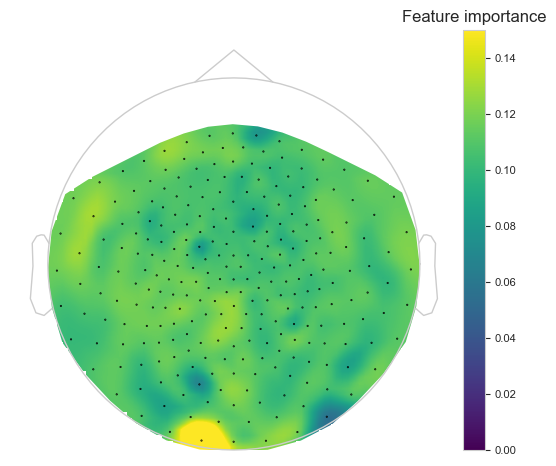

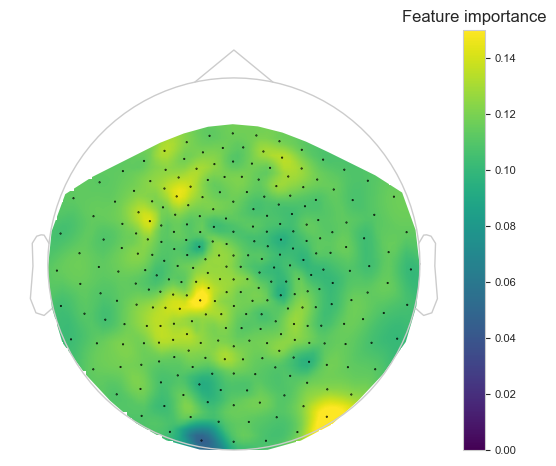

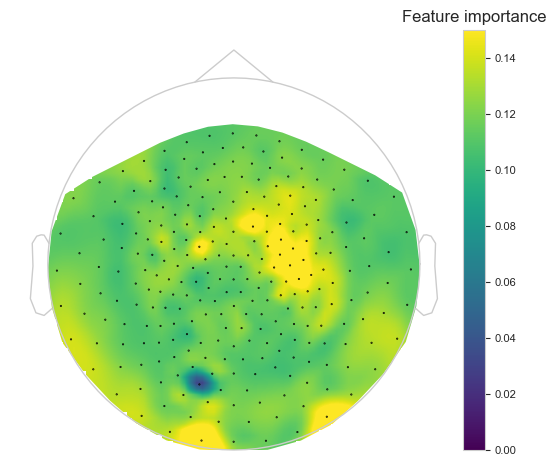

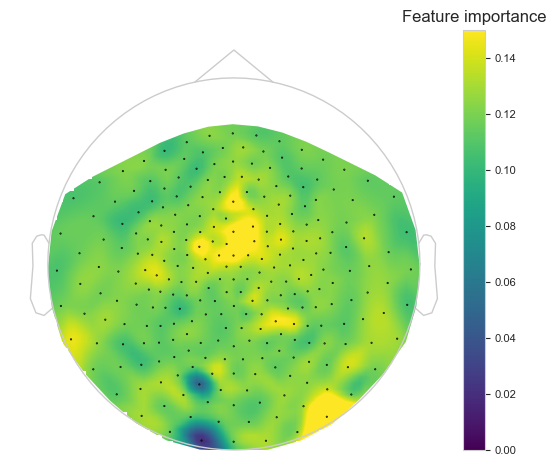

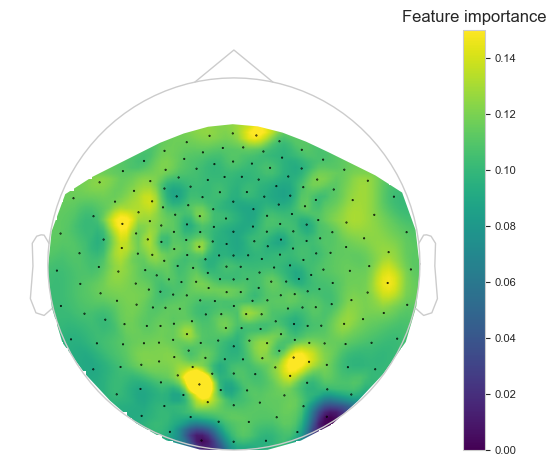

In [155]:

# reshape feature importances by changing the order of dimensions
feature_importances = np.array(feature_importances)
feature_importances_ = np.moveaxis(feature_importances, 0, -1)

vmax = np.max(feature_importances_)
for i in range(len(feature_importances_)):
    fig, ax = topoplot(
        feature_importances_[:][i],
        info,
        vmin=0,
        vmax=0.15,
        showtitle=True,
        figpath=os.path.join(reportpath, 'random_forest_feature_importances_RT2_'+str(i)+'.png'),
        ax_title="Feature importance",
        cmap="viridis",
        
    )


## Predict RS

In [17]:
import numpy as np
import pandas as pd
df = pd.read_csv('df_ALL_metadata_MEG_sub00to11_epo_RS_RS_run_corrected_3-90Hz.csv')

In [3]:
df.columns

Index(['electrodes', 'delta', 'theta', 'alpha', 'low_beta', 'high_beta',
       'gamma1', 'gamma2', '7', 'trials', 'bloc', 'participant', 'LZ', 'DAT',
       'n_obj', 'parei'],
      dtype='object')

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_val_predict, GridSearchCV, permutation_test_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

# replace column '7' by 'gamma3'
df = df.rename(columns={'7': 'gamma3'})
# Your frequency columns and data preparation remain the same
freq_cols = ['theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'gamma3', 'LZ']


# rescale all features
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#df[freq_cols] = scaler.fit_transform(df[freq_cols])

# rescale all features within participant
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for participant in df['participant'].unique():
    df.loc[df['participant'] == participant, freq_cols] = scaler.fit_transform(df.loc[df['participant'] == participant, freq_cols])


electrodes = df['electrodes'].unique()
groups = df['participant']
# Initialize metrics
balanced_accuracies = []
f1_scores = []
roc_auc_scores = []
feature_importances = []
p_values = []
all_permutation_scores = []

# Define hyperparameters for Grid Search
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'criterion': ['entropy']
}

# Define hyperparameters for Randomized Search (or Grid Search)
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 6, 10, 20, None],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Choose between GridSearchCV and RandomizedSearchCV
use_randomized_search = True
n_iter_search = 10  # Number of parameter settings sampled. Adjust as needed.


# Number of permutations
n_permutations = 1000
n_splits = len(df['participant'].unique())
print(f"Number of splits: {n_splits}")

# Group K-Fold for LOSO CV
sgkf = GroupKFold(n_splits=n_splits)

# Number of splits should match the number of unique participants

# Stratified Group K-Fold for LOSO CV
#gkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=False, random_state=None)
imputer = SimpleImputer(strategy='mean') 

for electrode in electrodes:
    sub_df = df[df['electrodes'] == electrode]
    X = sub_df[freq_cols]
    y = sub_df['bloc']
    groups = sub_df['participant']

    # Impute missing values in X
    X_imputed = imputer.fit_transform(X)
    print(f"X_imputed shape: {X_imputed.shape}")
    # Rest of your code
    clf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=sgkf)
    clf.fit(X_imputed, y, groups=groups)
    # Best estimator
    best_clf = clf.best_estimator_

    # Initialize the classifier with Grid Search or Randomized Search
    if use_randomized_search:
        search_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                       param_distributions, n_iter=n_iter_search, cv=sgkf, scoring='balanced_accuracy')
    else:
        search_cv = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                                 param_grid, cv=sgkf, scoring='balanced_accuracy')

    # Fit the model
    search_cv.fit(X_imputed, y, groups=groups)

    # Best estimator
    best_clf = search_cv.best_estimator_

    # Permutation Test Score
    score, permutation_scores, pvalue = permutation_test_score(
        best_clf, X_imputed, y, scoring="balanced_accuracy", cv=sgkf, n_permutations=n_permutations, groups=groups, n_jobs=-1)
    print(pvalue)
    # Make predictions and calculate additional metrics
    # Use cross_val_predict to get prediction probabilities for ROC-AUC
    #predicted_probs = cross_val_predict(best_clf, X_imputed, y, cv=sgkf, groups=groups, method="predict_proba", n_jobs=-1)

    # Compute class predictions from probabilities for F1-score
    # Assuming positive class is represented by the second column (index 1)
    #predictions = (predicted_probs[:, 1] > 0.5).astype(int)
    all_permutation_scores.append(permutation_scores)
    # Compute F1-score
    #f1 = f1_score(y, predictions)

    # Compute ROC-AUC using the probabilities of the positive class
    #roc_auc = roc_auc_score(y, predicted_probs[:, 1])

    # Store results
    balanced_accuracies.append(search_cv.best_score_)
    #f1_scores.append(f1)
    #roc_auc_scores.append(roc_auc)
    feature_importances.append(best_clf.feature_importances_)
    p_values.append(pvalue)
    print(f"Electrode {electrode}: Balanced Accuracy = {search_cv.best_score_:.4f}, Best Params: {search_cv.best_params_}")
print(f"Balanced Accuracies: {balanced_accuracies}")
print(f"P-values: {p_values}")


Number of splits: 12
X_imputed shape: (1397, 8)
0.23376623376623376
Electrode 0: Balanced Accuracy = 0.5114, Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 6, 'criterion': 'gini'}
X_imputed shape: (1397, 8)
0.14685314685314685
Electrode 1: Balanced Accuracy = 0.5157, Best Params: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 2, 'criterion': 'gini'}
X_imputed shape: (1397, 8)
0.000999000999000999
Electrode 2: Balanced Accuracy = 0.5504, Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 2, 'criterion': 'gini'}
X_imputed shape: (1397, 8)
0.027972027972027972
Electrode 3: Balanced Accuracy = 0.5264, Best Params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 2, 'criterion': 'gini'}
X_imputed shape: (1397, 8)
0.4965034965034965
Electrode 4: Balanced Accuracy = 0.5002, Best Params: {'n_estimators': 300, 'min_samples_split': 5, 'm

In [19]:
# save all in a folder
# create a folder
foldername = 'Strat_LOSO_RF_RestingState_results0_1000permutation_test_grid_search_withinsubjscaling_max_FOOOF'
import os
os.mkdir(foldername)
import pickle
pickle.dump(balanced_accuracies, open(foldername + '/balanced_accuracies.pkl', 'wb'))
#pickle.dump(f1_scores, open('Strat_LOSO_RF_RestingState_results0_permutation_test_grid_search_withinsubjscaling/f1_scores.pkl', 'wb'))
#pickle.dump(roc_auc_scores, open('Strat_LOSO_RF_RestingState_results0_permutation_test_grid_search_withinsubjscaling/roc_auc_scores.pkl', 'wb'))
pickle.dump(feature_importances, open(foldername + '/feature_importances.pkl', 'wb'))
pickle.dump(p_values, open(foldername + '/p_values.pkl', 'wb'))
pickle.dump(all_permutation_scores, open(foldername + '/all_permutation_scores.pkl', 'wb'))

pickle.dump(best_clf, open(foldername + '/best_clf.pkl', 'wb'))
# create dataframe with feautre importance and their names
import pandas as pd
feature_names = X.columns
feature_importances_df = pd.DataFrame(feature_importances, columns=feature_names)
feature_importances_df.to_csv(foldername + '/feature_importances.csv')
# save all models
#import os
#os.mkdir('Strat_LOSO_RF_RestingState_results01/models')

#for i in range(len(balanced_accuracies)):
#    pickle.dump(best_clf, open('Strat_LOSO_RF_RestingState_results01/models/best_clf'+str(i)+'.pkl', 'wb'))



In [20]:
# Aggregate the permutation scores
max_perm_scores = np.max(np.column_stack(all_permutation_scores), axis=1)

# Calculate adjusted p-values
adjusted_p_values = []
for i in range(len(p_values)):
    observed_score = balanced_accuracies[i]
    adjusted_p_value = np.mean(max_perm_scores >= observed_score)
    adjusted_p_values.append(adjusted_p_value)
    print(f"Electrode {electrodes[i]}: Adjusted p-value = {adjusted_p_value:.4f}")

Electrode 0: Adjusted p-value = 1.0000
Electrode 1: Adjusted p-value = 1.0000
Electrode 2: Adjusted p-value = 0.1320
Electrode 3: Adjusted p-value = 1.0000
Electrode 4: Adjusted p-value = 1.0000
Electrode 5: Adjusted p-value = 1.0000
Electrode 6: Adjusted p-value = 0.8560
Electrode 7: Adjusted p-value = 0.5740
Electrode 8: Adjusted p-value = 0.8030
Electrode 9: Adjusted p-value = 0.0050
Electrode 10: Adjusted p-value = 1.0000
Electrode 11: Adjusted p-value = 1.0000
Electrode 12: Adjusted p-value = 0.0010
Electrode 13: Adjusted p-value = 0.0580
Electrode 14: Adjusted p-value = 0.0090
Electrode 15: Adjusted p-value = 0.1040
Electrode 16: Adjusted p-value = 0.1670
Electrode 17: Adjusted p-value = 0.8670
Electrode 18: Adjusted p-value = 0.6900
Electrode 19: Adjusted p-value = 0.8200
Electrode 20: Adjusted p-value = 0.9440
Electrode 21: Adjusted p-value = 1.0000
Electrode 22: Adjusted p-value = 0.2690
Electrode 23: Adjusted p-value = 0.0560
Electrode 24: Adjusted p-value = 1.0000
Electrode 

In [219]:
path = 'Strat_LOSO_RF_RestingState_results0_1000permutation_test_grid_search_withinsubjscaling/'
feature_importances = pd.read_csv(path + 'feature_importances_df.csv')
feature_importances = feature_importances.drop(columns=['Unnamed: 0'])
feature_names = feature_importances.columns

# remove 'DAT', 'parei', 'n_obj'
feature_importances = feature_importances.drop(columns=['DAT', 'parei', 'n_obj'])
feature_names = feature_importances.columns
# convert to numpy array
feature_importances = feature_importances.to_numpy()
# plot feature importance
import matplotlib.pyplot as plt
#feature_importances = np.moveaxis(feature_importances, 0, -1)
# Get feature names
#feature_names = X.columns

# Get mean feature importance
mean_feature_importance = np.mean(feature_importances, axis=0)

# Sort feature importances in descending order
sorted_idx = np.argsort(mean_feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5

# Plot the result
plt.figure(figsize=(9, 6))
plt.bar(pos, mean_feature_importance[sorted_idx], align='center', color='purple')
plt.xticks(pos, feature_names[sorted_idx], rotation=90, ha='center')
plt.xlabel('Features', fontsize=25)
plt.ylabel('Mean Feature Importance', fontsize=25)
plt.title('Feature Importance', fontsize=35)
# change font size of ticks
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig(path + 'feature_importances.png')
plt.show()


In [25]:
feature_importances

[array([0.27239198, 0.0954872 , 0.05944764, 0.07856277, 0.09158227,
        0.18587725, 0.15364643, 0.06300448]),
 array([0.17472918, 0.093851  , 0.09933393, 0.12159144, 0.15294968,
        0.12277706, 0.12944876, 0.10531895]),
 array([0.19097154, 0.07736885, 0.04304834, 0.11095031, 0.17473513,
        0.1543361 , 0.20754521, 0.04104452]),
 array([0.1497652 , 0.06854584, 0.11674878, 0.11872017, 0.15134293,
        0.16749099, 0.17480639, 0.05257971]),
 array([0.13168999, 0.11350128, 0.13659284, 0.12579364, 0.12591065,
        0.13465254, 0.1220757 , 0.10978337]),
 array([0.1266664 , 0.11327576, 0.1169912 , 0.13133583, 0.13381984,
        0.13395924, 0.12529192, 0.11865983]),
 array([0.12080295, 0.11507165, 0.1270855 , 0.1298874 , 0.12085391,
        0.12654084, 0.14518021, 0.11457753]),
 array([0.21350141, 0.07399836, 0.02011525, 0.11037526, 0.23785303,
        0.1551583 , 0.1119775 , 0.07702087]),
 array([0.14116971, 0.07824507, 0.03007877, 0.12847446, 0.1773152 ,
        0.20057039, 

In [23]:
path = 'Strat_LOSO_RF_RestingState_results0_1000permutation_test_grid_search_withinsubjscaling_max_FOOOF/'
#feature_importances = pd.read_csv(path + 'feature_importances_df.csv')
#feature_importances = feature_importances.drop(columns=['Unnamed: 0'])
feature_names = feature_importances_df.columns

# remove 'DAT', 'parei', 'n_obj'
#feature_importances = feature_importances_df.drop(columns=['DAT', 'parei', 'n_obj'])
feature_names = feature_importances_df.columns
# convert to numpy array
feature_importances = feature_importances_df.to_numpy()
# plot feature importance
import matplotlib.pyplot as plt
#feature_importances = np.moveaxis(feature_importances, 0, -1)
# Get feature names
#feature_names = X.columns

# Get mean feature importance
mean_feature_importance = np.mean(feature_importances, axis=0)

# Sort feature importances in descending order
sorted_idx = np.argsort(mean_feature_importance)[::-1]
pos = np.arange(sorted_idx.shape[0]) + .5
feature_importances_df = pd.DataFrame(feature_importances, columns=feature_names)
# order by feature importance
feature_importances_df = feature_importances_df[feature_names[sorted_idx]]
# replace low_beta by Low Beta, high_beta by High Beta, gamma1 by Gamma1, gamma2 by Gamma2, theta by Theta, alpha by Alpha, delta by Delta
feature_importances_df = feature_importances_df.rename(columns={'low_beta': 'Low Beta', 'high_beta': 'High Beta', 'gamma1': 'Gamma1', 'gamma2': 'Gamma2', 'theta': 'Theta', 'alpha': 'Alpha', 'gamma3': 'Gamma3'})

# Plot the result using violin plot using one color for each feature using seaborn, in order to see the distribution of feature importance
import seaborn as sns
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))
sns.violinplot(data=feature_importances_df, ax=ax)
ax.set_xlabel("Features", fontsize=25)
ax.set_ylabel("Feature Importance", fontsize=25)
#ax.set_title("Feature Importance", fontsize=35)
plt.xticks(rotation=90, fontsize=22)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig(path + 'feature_importances_violin2.png')
plt.show()

In [83]:
import pandas as pd

# Assuming df is your DataFrame and n_obj_class is the target variable
# participants are identified by the column 'participant'

# Group the data by participant and count the occurrences of each class in n_obj_class
class_distribution = df.groupby('participant')['bloc'].value_counts(normalize=True).unstack(fill_value=0)

# Convert the class distribution to percentages
class_distribution_percentage = class_distribution * 100

# Print the class distribution for each participant
print(class_distribution_percentage)


bloc                0         1
participant                    
0            50.00000  50.00000
1            50.00000  50.00000
2            59.59596  40.40404
3            50.00000  50.00000
4            50.00000  50.00000
5            50.00000  50.00000
6            50.00000  50.00000
7            50.00000  50.00000
8            50.00000  50.00000
9            50.00000  50.00000
10           50.00000  50.00000
11           50.00000  50.00000


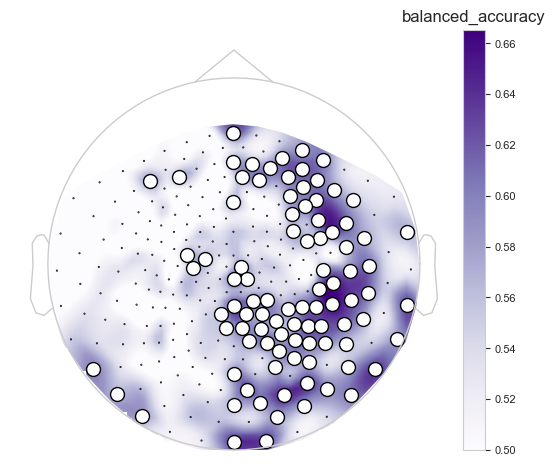

In [24]:
# load balanced accuracies
import pickle
#balanced_accuracies = pickle.load(open('Strat_LOSO_RF_RestingState_results0_permutation_test_grid_search_withinsubjscaling_max/balanced_accuracies.pkl', 'rb'))
#p_values = pickle.load(open('Strat_LOSO_RF_RestingState_results0_permutation_test_grid_search_withinsubjscaling_max/p_values.pkl', 'rb'))

reportpath = 'C:/Users/Antoine/github/MEG_pareidolia/Merged_dataframes/Strat_LOSO_RF_RestingState_results0_1000permutation_test_grid_search_withinsubjscaling_max_FOOOF/'
metric = balanced_accuracies
metric_name = 'balanced_accuracy'
# create mask for p-values
p_values = np.array(adjusted_p_values)
p_values_mask = p_values < 0.01
# create mask for feature importance
fig, ax = topoplot(
        metric,
        info,
        vmin=0.5,
        vmax=np.max(metric),
        showtitle=True,
        figpath=os.path.join(reportpath, f'random_forest_{metric_name}_RS_max_01.png'),
        ax_title=metric_name,
        cmap='Purples',
        mask=p_values_mask,
    )

In [38]:
adjusted_p_values

[0.006,
 0.19,
 0.044,
 0.469,
 0.82,
 0.989,
 0.984,
 0.07,
 0.001,
 0.223,
 0.934,
 1.0,
 0.0,
 0.0,
 0.147,
 0.082,
 0.0,
 0.0,
 0.002,
 0.0,
 0.0,
 0.092,
 0.0,
 0.0,
 1.0,
 1.0,
 0.947,
 1.0,
 1.0,
 0.974,
 0.0,
 0.0,
 0.0,
 1.0,
 0.632,
 0.231,
 1.0,
 0.496,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.649,
 1.0,
 1.0,
 0.978,
 0.954,
 0.103,
 1.0,
 1.0,
 1.0,
 1.0,
 0.974,
 1.0,
 0.999,
 1.0,
 0.999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.999,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.294,
 0.042,
 0.0,
 0.027,
 1.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 0.251,
 0.0,
 1.0,
 1.0,
 0.999,
 0.013,
 0.998,
 1.0,
 1.0,
 1.0,
 0.0,
 0.02,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.081,
 0.837,
 1.0,
 1.0,
 1.0,
 1.0,
 0.005,
 0.943,
 1.0,
 0.086,
 0.992,
 1.0,
 0.999,
 1.0,
 0.999,
 1.0,
 0.952,
 0.999,
 1.0,
 0.003,
 1.0,
 1.0,
 1.0,
 1.0,
 0.204,
 0.116,
 0.01,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.982,
 0.179,
 0.868,
 0.942,
 0.999,
 1.0,
 0.832,
 0.362,
 0.963,
 0.116,
 1.0,
 0.021,
 0.027,
 0.002,
 1.0,
 0.0

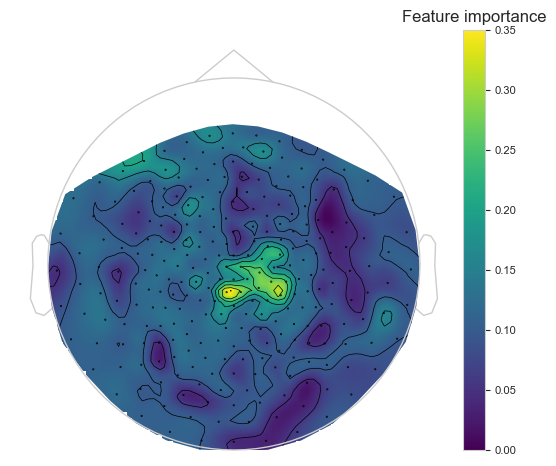

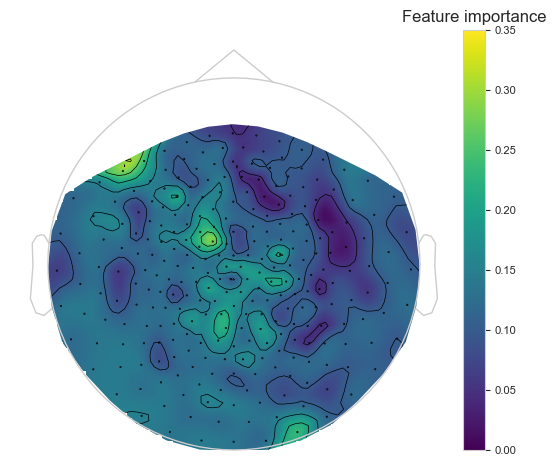

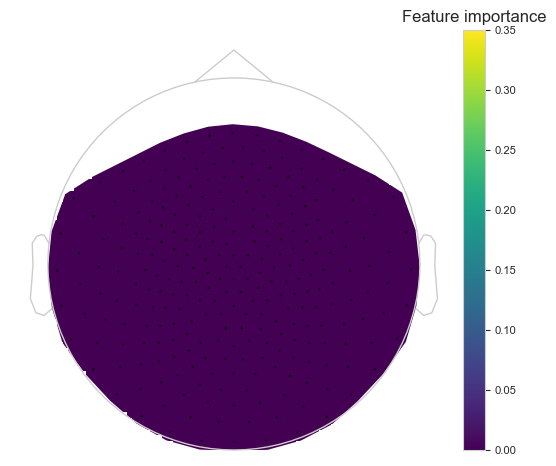

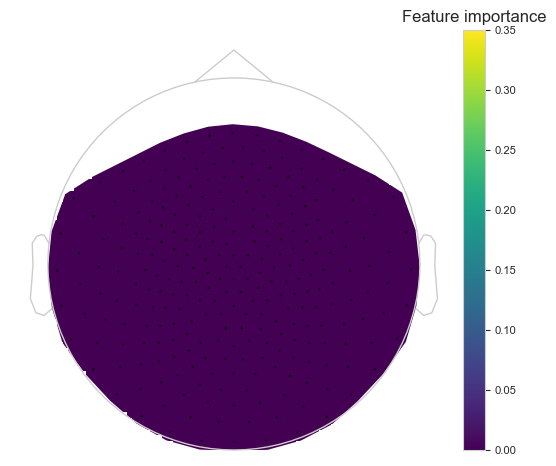

In [127]:

# reshape feature importances by changing the order of dimensions
feature_importances = np.array(feature_importances)
feature_importances = np.moveaxis(feature_importances, 0, -1)

vmax = np.max(feature_importances)
for i in range(len(feature_importances)):
    fig, ax = topoplot(
        feature_importances[:][i],
        info,
        vmin=0,
        vmax=0.35,
        showtitle=True,
        figpath=os.path.join(reportpath, 'random_forest_feature_importances_RS'+str(i)+'.png'),
        ax_title="Feature importance",
        cmap="viridis",
        
    )


In [84]:
mean_importances

array([0.11273795, 0.1135701 , 0.11639812, 0.11629479, 0.1196887 ,
       0.12240826, 0.12536802, 0.09700259, 0.07653147])

KeyError: 'delta'

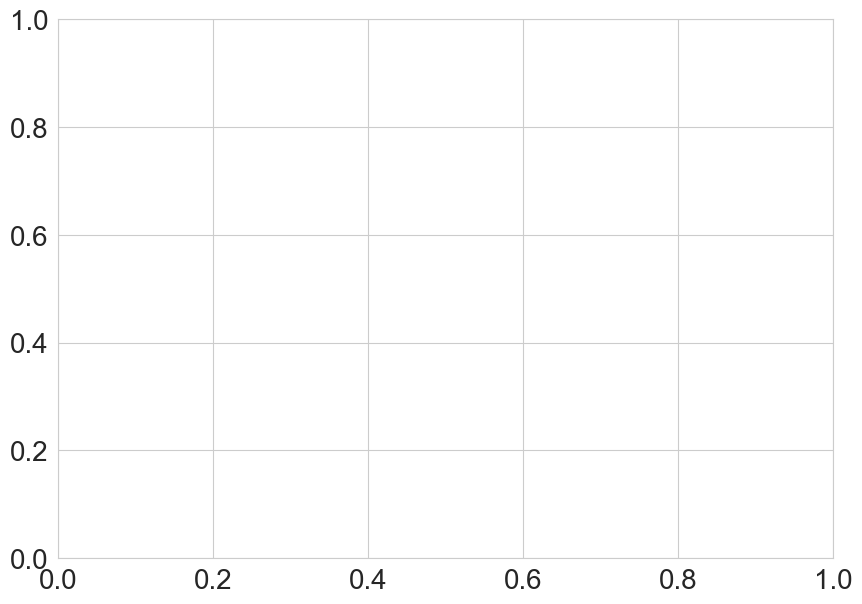

In [83]:
import seaborn as sns
# plot feature importances

# Get the mean feature importances across electrodes
mean_importances = np.mean(feature_importances, axis=0)

# Plot the feature importances
fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(x=freq_cols, y=mean_importances, ax=ax)
plt.title("Feature Importances")
plt.xlabel("Frequency Bands")
plt.ylabel("Importance")
plt.show()

### Hyperparameter tuning

In [85]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

freq_cols = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'LZ']

# Assuming you have an 'electrodes' column in df that specifies the electrode
electrodes = df['electrodes'].unique()

# Store results
results = {
    'RandomForest': [],
    'SVC': []
}
feature_importances = []

# Parameters for grid search
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

clfs = {
    'RandomForest': GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3),
    'SVC': GridSearchCV(SVC(random_state=42), param_grid_svc, cv=3)
}

# LOSO CV
gkf = GroupKFold(n_splits=len(groups.unique()))

for electrode in electrodes:
    # Filter data for current electrode
    sub_df = df[df['electrodes'] == electrode]
    X = sub_df[freq_cols + ['n_obj']]
    y = sub_df['sham_cond_num']
    groups = sub_df['participant']

    # Standardizing the data for SVC
    scaler = StandardScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    for clf_name, clf in clfs.items():
        # We'll use cross_val_predict to get predicted labels and then compute balanced accuracy
        if clf_name == 'SVC':
            predicted_labels = cross_val_predict(clf, X_scaled, y, groups=groups, cv=gkf)
        else:
            predicted_labels = cross_val_predict(clf, X, y, groups=groups, cv=gkf)
            
        acc = balanced_accuracy_score(y, predicted_labels)
        results[clf_name].append(acc)

        # Train on the full electrode data to get feature importances (only for RF)
        if clf_name == 'RandomForest':
            clf.fit(X, y)
            importance = clf.best_estimator_.feature_importances_
            feature_importances.append(importance)

        print(f"Electrode {electrode}, Classifier {clf_name}: {acc:.4f}")



Electrode 0, Classifier RandomForest: 0.5349
Electrode 0, Classifier SVC: 0.5565
Electrode 1, Classifier RandomForest: 0.5120
Electrode 1, Classifier SVC: 0.5625
Electrode 2, Classifier RandomForest: 0.5204
Electrode 2, Classifier SVC: 0.5553
Electrode 3, Classifier RandomForest: 0.5300
Electrode 3, Classifier SVC: 0.5469
Electrode 4, Classifier RandomForest: 0.5385
Electrode 4, Classifier SVC: 0.5505
Electrode 5, Classifier RandomForest: 0.5240
Electrode 5, Classifier SVC: 0.5829
Electrode 6, Classifier RandomForest: 0.5072
Electrode 6, Classifier SVC: 0.5733
Electrode 7, Classifier RandomForest: 0.5349
Electrode 7, Classifier SVC: 0.5685
Electrode 8, Classifier RandomForest: 0.5601
Electrode 8, Classifier SVC: 0.5625
Electrode 9, Classifier RandomForest: 0.5649
Electrode 9, Classifier SVC: 0.5781
Electrode 10, Classifier RandomForest: 0.5493
Electrode 10, Classifier SVC: 0.5853
Electrode 11, Classifier RandomForest: 0.5144
Electrode 11, Classifier SVC: 0.5793
Electrode 12, Classifier

NameError: name 'list_of_channel_names' is not defined

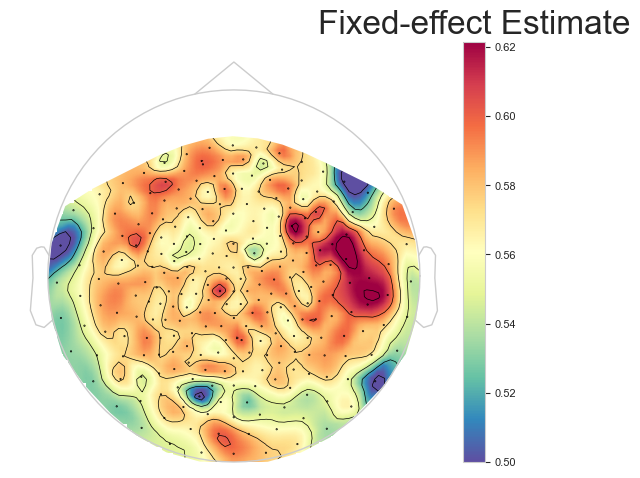

In [89]:
reportpath = 'C:/Users/Antoine/github/MEG_pareidolia/'
fig, ax = topoplot(
        results['SVC'],
        info,
        vmin=0.5,
        vmax=np.max(balanced_accuracies),
        showtitle=True,
        figpath=os.path.join(reportpath, 'random_forest_balanced_accuracies_Sham.png'),
        ax_title="Fixed-effect Estimate",
    )

## GLMs

In [40]:
import pandas as pd
import statsmodels.formula.api as smf
import mne
import numpy as np

# Sample data load
# df = pd.read_csv('path_to_your_data.csv')

df['sham_cond_num'] = df['sham_cond'].map({'down': 0, 'up': 1})
# Z-score the frequency columns
freq_cols = ['delta', 'theta', 'alpha', 'low_beta', 'high_beta', 'gamma1', 'gamma2', 'LZ']
freq_cols = ['n_obj', 'DAT', 'sham_cond_num']
df[freq_cols] = (df[freq_cols] - df[freq_cols].mean()) / df[freq_cols].std()
#interaction_terms = ["FD:"+col for col in freq_cols]
# create interaction terms with all possible pairs of two-way interactions
interaction_terms = []
for i in range(len(freq_cols)):
    for j in range(i+1, len(freq_cols)):
        interaction_terms.append(freq_cols[i] + ":" + freq_cols[j])
all_terms = freq_cols + interaction_terms
# Assuming you have a column named 'electrodes' in df that specifies the electrode number
electrodes = df['electrodes'].unique()

# Create a dictionary to store the mixed-effects results for each electrode
results = {}
effects = {col: [] for col in all_terms}  # To store effects for each frequency band
pv = {col: [] for col in all_terms}  # To store p-values for each frequency band

for electrode in electrodes:
    # Subset data for current electrode
    sub_df = df[df['electrodes'] == electrode]
    
    print(f"Running mixed-effects model for electrode {electrode}")
    formula = "theta ~ " + " + ".join(all_terms)
    # Fit a mixed-effects model with the formula and a random intercept for each participant
    model = smf.mixedlm(formula, sub_df, groups=sub_df["participant"])
    result = model.fit()
    results[electrode] = result

    # Extract fixed effects for each frequency band and store
    for effect in freq_cols + interaction_terms:
        effects[effect].append(result.params[effect])
        pv[effect].append(result.pvalues[effect])

# Plotting topomaps
# This requires electrode locations. Assuming you have them in a standard format:
# info = mne.create_info(ch_names=list_of_channel_names, sfreq=sample_frequency, ch_types='eeg')




Running mixed-effects model for electrode 0
Running mixed-effects model for electrode 1
Running mixed-effects model for electrode 2
Running mixed-effects model for electrode 3
Running mixed-effects model for electrode 4
Running mixed-effects model for electrode 5
Running mixed-effects model for electrode 6
Running mixed-effects model for electrode 7
Running mixed-effects model for electrode 8
Running mixed-effects model for electrode 9
Running mixed-effects model for electrode 10
Running mixed-effects model for electrode 11
Running mixed-effects model for electrode 12
Running mixed-effects model for electrode 13
Running mixed-effects model for electrode 14
Running mixed-effects model for electrode 15
Running mixed-effects model for electrode 16
Running mixed-effects model for electrode 17
Running mixed-effects model for electrode 18
Running mixed-effects model for electrode 19
Running mixed-effects model for electrode 20
Running mixed-effects model for electrode 21
Running mixed-effect

In [106]:
import pandas as pd
import statsmodels.formula.api as smf
import mne
import numpy as np

# Sample data load
# df = pd.read_csv('path_to_your_data.csv')
df['FD2'] = df['FD']**2
# Z-score the frequency columns
freq_cols = ['LZ', 'SFD', 'PFD', 'KFD', 'Hjorth', 'n_obj']
df[freq_cols] = (df[freq_cols] - df[freq_cols].mean()) / df[freq_cols].std()
interaction_terms = ["sham_cond_num:"+col for col in freq_cols]
all_terms = freq_cols + interaction_terms
# Assuming you have a column named 'electrodes' in df that specifies the electrode number
electrodes = df['electrodes'].unique()

# Create a dictionary to store the mixed-effects results for each electrode
results = {}
effects = {col: [] for col in all_terms}  # To store effects for each frequency band
pv = {col: [] for col in all_terms}  # To store p-values for each frequency band

for electrode in electrodes:
    # Subset data for current electrode
    sub_df = df[df['electrodes'] == electrode]
    
    
    formula = "FD2 ~ " + " + ".join(all_terms)
    # Fit a mixed-effects model with the formula and a random intercept for each participant
    model = smf.mixedlm(formula, sub_df, groups=sub_df["participant"])
    result = model.fit()
    results[electrode] = result

    # Extract fixed effects for each frequency band and store
    for effect in freq_cols + interaction_terms:
        effects[effect].append(result.params[effect])
        pv[effect].append(result.pvalues[effect])

# Plotting topomaps
# This requires electrode locations. Assuming you have them in a standard format:
# info = mne.create_info(ch_names=list_of_channel_names, sfreq=sample_frequency, ch_types='eeg')




c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Antoine\anaconda3\envs\biotuner\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum L

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif ...


C:\Users\Antoine\AppData\Local\Temp\ipykernel_43332\305229815.py:5: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_long.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -1500.00 ...    8000.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


In [29]:
results[1].params

Intercept              0.714985
n_obj                  0.000151
DAT                    0.001162
sham_cond_num         -0.000767
n_obj:DAT             -0.000108
n_obj:sham_cond_num   -0.000519
DAT:sham_cond_num      0.000483
Group Var              3.148442
dtype: float64

69
69


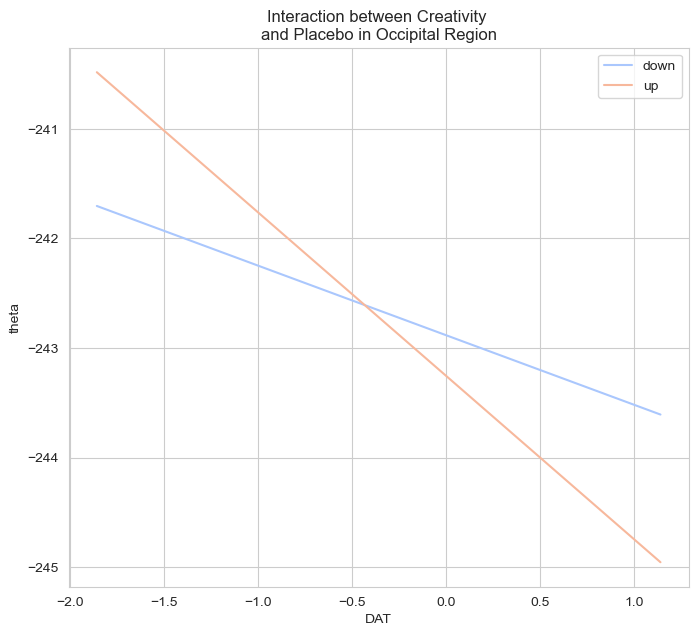

In [44]:
var = 'DAT'
vars = ['DAT', 'LZ', 'n_obj']
# add quadratic term for FD

# Extract the fixed effects for the interaction term across all electrodes
interaction_values = {electrode: results[electrode].params.get(f"{var}:sham_cond_num", 0) for electrode in electrodes}

# Find the electrode with the highest absolute fixed-effect value for the interaction term
max_electrode = min(interaction_values, key=lambda electrode: interaction_values[electrode])

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for the electrode with the highest interaction effect
sub_df = df[df['electrodes'] == max_electrode]


# Set the style of Seaborn
sns.set_style("whitegrid")

# Create a scatter plot of the data
plt.figure(figsize=(8, 7))
# Create a color palette for unique sham conditions
unique_sham_conds = sub_df['sham_cond_num'].unique()
#order the sham conditions
unique_sham_conds.sort()
sham_cond_names = ['down', 'up']
palette = sns.color_palette("coolwarm", n_colors=len(unique_sham_conds))
color_map = dict(zip(unique_sham_conds, palette))

# Scatter plot using explicit color mapping
#sns.scatterplot(data=sub_df, x="gamma1", y="n_obj", hue="sham_cond_num", palette=color_map)

gamma1_values = np.linspace(sub_df[var].min(), sub_df[var].max(), 100)
for sham_cond, sham_name in zip(unique_sham_conds, sham_cond_names):
    pred_df = pd.DataFrame({var: gamma1_values, 'sham_cond_num': [sham_cond] * 100})
    # remove var from vars
    vars_ = vars.copy()
    vars_.remove(var)
    # Fill with mean values of other predictors
    for col in vars_:
        pred_df[col] = df[col].mean()

    pred_values = results[max_electrode].predict(pred_df)
    plt.plot(gamma1_values, pred_values, color=color_map[sham_cond], label=sham_name)
    #print max elec
    print(max_electrode)
plt.title("Interaction between Creativity \nand Placebo in Occipital Region")
plt.xlabel(var)
plt.ylabel("theta")
plt.legend()
#plt.savefig('C:/Users/Antoine/github/MEG_pareidolia/OUTPUTS/sham_topomaps/interaction_gamma2_sham_occi.png')
plt.show()


In [9]:
def topoplot(
    toplot,
    ch_xy,
    showtitle=False,
    titles=None,
    savefig=True,
    figpath=r"C:\Users\Dell\Jupyter\BrainHackSchool2019_AB\EEG_music_scripts",
    vmin=None,
    vmax=None,
    ax_title="t values",
    mask=None,
    cmap="viridis",
):
    # create fig
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    # create a topomap for each data array
    if vmin == None:
        vmin = np.min(toplot)
    if vmax == None:
        vmax = np.max(toplot)
    image, _ = mne.viz.plot_topomap(
        data=toplot,
        pos=ch_xy,
        cmap=cmap,
        vlim=[vmin, vmax],
        outlines="head",
        sphere=0.19,
        axes=ax,
        show=False,
        mask=mask,
        contours=0,
        mask_params=dict(markersize=10, markerfacecolor="w", markeredgecolor="k", linewidth=0.1, alpha=0.8),
    )
    # option for title
    if showtitle == True:
        ax.set_title(titles, fontdict={"fontsize": 10, "fontweight": "heavy"})
    # add a colorbar at the end of the line (weird trick from https://www.martinos.org/mne/stable/auto_tutorials/stats-sensor-space/plot_stats_spatio_temporal_cluster_sensors.html#sphx-glr-auto-tutorials-stats-sensor-space-plot-stats-spatio-temporal-cluster-sensors-py)
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    divider = make_axes_locatable(ax)
    ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(image, cax=ax_colorbar)
    ax_colorbar.set_title(ax_title, fontdict={"fontsize": 13, "fontweight": "heavy"})
    ax_colorbar.tick_params(labelsize=10)
    # save plot if specified
    if savefig == True:
        plt.tight_layout()
        plt.savefig(figpath, dpi=300, transparent=True)
    # plt.show()
    return fig, ax

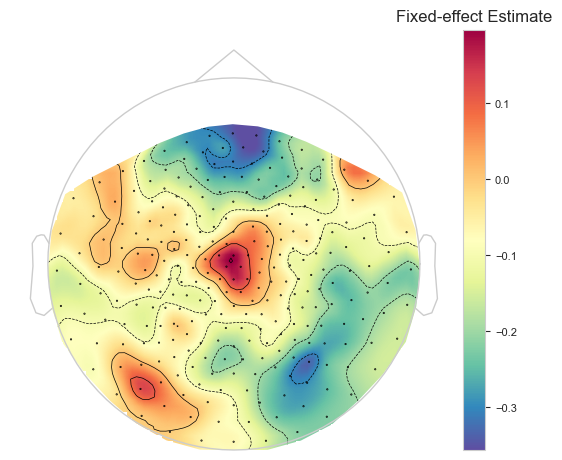

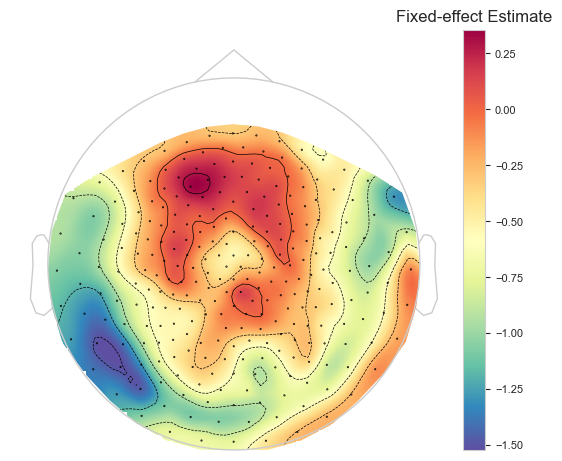

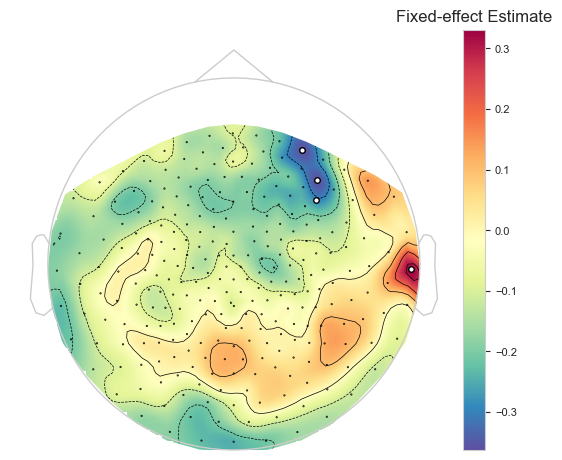

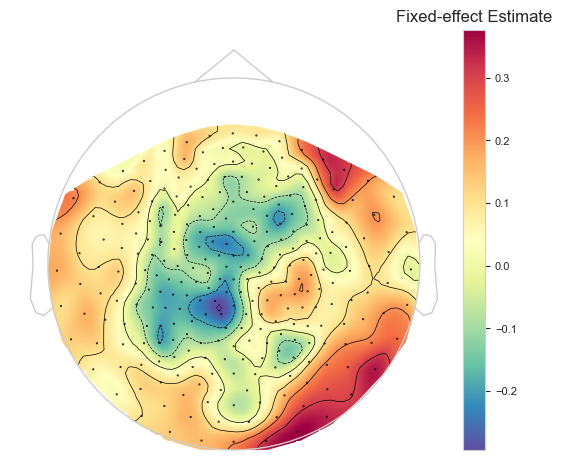

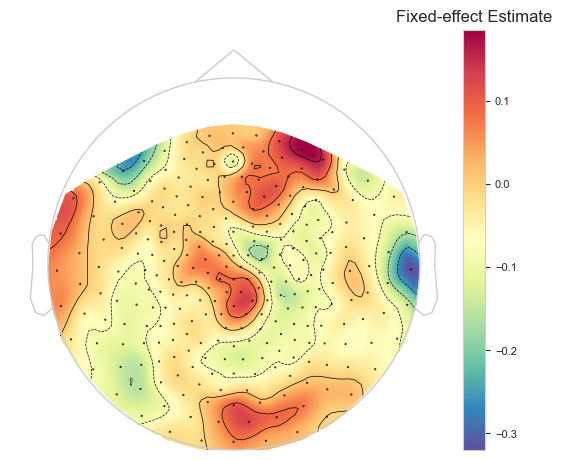

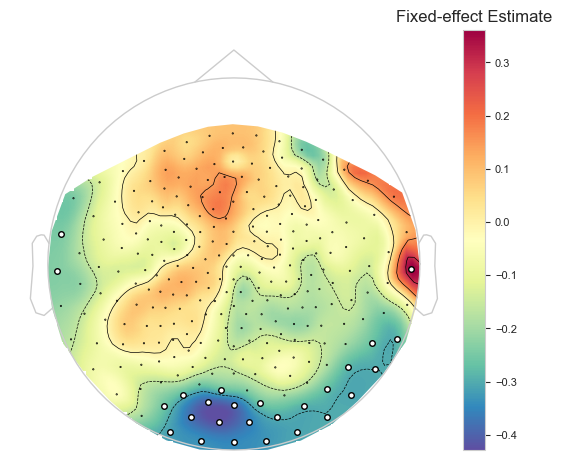

In [42]:
reportpath = '../OUTPUTS/sham_topomaps'
import os
if not os.path.exists(reportpath):
    os.makedirs(reportpath)

FDR=True
pval_thresh=0.05

# Use a consistent colormap for all plots
cmap = 'coolwarm'
all_values = []
for electrode in electrodes:
    all_values.append(results[electrode].params)
extreme = np.max(np.abs(all_values))
vmax = extreme
vmin = -extreme
for col in all_terms:
    data = np.array(effects[col])
    pvals = np.array(pv[col])
    
    if FDR is True:
        _, pvals = fdrcorrection(pvals, alpha=pval_thresh, method="indep")
    
    mask = p_values_boolean_1d(pvals, threshold=pval_thresh)

    
    
    # remove : from col for filename
    filename_col = col.replace(':', 'BY')
    
    fig, ax = topoplot(
        data,
        info,
        vmin=-0.2,
        vmax=0.2,
        showtitle=True,
        mask=mask,
        figpath=os.path.join(reportpath, f'topoplot_{filename_col}_sham_theta_FD_norand_nobj.png'),
        ax_title="Fixed-effect Estimate",
    )


In [17]:
print(models[100].summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    DAT   No. Observations:                  832
Model:                            GLM   Df Residuals:                      824
Model Family:                Gaussian   Df Model:                            7
Link Function:               identity   Scale:                          11.710
Method:                          IRLS   Log-Likelihood:                -2200.1
Date:                Wed, 01 Nov 2023   Deviance:                       9649.4
Time:                        23:55:08   Pearson chi2:                 9.65e+03
No. Iterations:                     3   Pseudo R-squ. (CS):            0.08107
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.4945      0.197    448.979      0.0

In [60]:
mdf2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
           Mixed Linear Model Regression Results
===========================================================
Model:             MixedLM Dependent Variable: n_obj       
No. Observations:  224640  Method:             REML        
No. Groups:        8       Scale:              0.8588      
Min. group size:   28080   Log-Likelihood:     -301723.8082
Max. group size:   28080   Converged:          Yes         
Mean group size:   28080.0                                 
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept         0.627    0.145  4.311 0.000  0.342  0.912
sham_cond_num     0.231    0.021 10.852 0.000  0.189  0.272
FD                0.263    0.210  1.255 0.209 -0.148  0.674
sham_cond_num:FD  0.256    0.014 18.400 0.000  0.229  0.284
Group Var         0.167    0.110                           
Group x FD Cov   -0.015    0.100                           
FD Var            0.351    0.181                           
===========================================================

"""

In [23]:
# Questionnaires_Infos_perso_MEG

infos_perso = pd.read_csv('../questionnaire_data_perso/Questionnaires_Infos_perso_MEG.csv')
infos_perso

Horodateur  Numéro de participant              Nom       Prénom  \
0   01/04/2021 13:17:25                    0.0            Harel         Yann   
1   10/05/2021 16:39:46                    1.0  Savard-Beaudoin       Maxime   
2   11/05/2021 19:37:48                    2.0          Couture    Tristan-B   
3   26/05/2021 09:12:10                    3.0     Brault-Miron   Guillaume    
4   10/06/2021 09:14:44                    4.0      El khantour        Clara   
5   17/06/2021 10:23:14                    5.0           TIFFET     FREDERIC   
6   07/12/2021 12:20:07                    6.0          O'Byrne       Jordan   
7   21/12/2021 09:38:18                    7.0         Galipeau       Sophie   
8   21/12/2021 13:18:18                    8.0            Silva  Christopher   
9   08/02/2022 09:15:29                    9.0         Cloutier      Mathieu   
10                  NaN                    NaN              NaN          NaN   
11  27/02/2022 14:08:15                   10.0          Maschke    Charlotte   
12  27/02/2022 19:32:12                   11.0           Paugam     Francois   

    Genre   Âge  Lieu de naissance        Ethnicité  \
0   Homme  27.0       Lyon, FRANCE        Caucasien   
1   Homme  30.0           Longueil        Causasian   
2   Homme  27.0              Paris        Quebecois   
3   Homme  37.0           Montreal              Oui   
4   Femme  19.0   Saverne (France)         Europeen   
5   Homme  29.0           MONTREAL        CAUCASIEN   
6   Homme  34.0         Ottawa, ON  blanc/caucasien   
7   Femme  27.0           Montreal            blanc   
8   Homme  30.0           New-York        Caucasian   
9   Homme  30.0  Longueuil, Qc, ca        Caucasien   
10    NaN   NaN                NaN              NaN   
11  Femme  25.0          Allemagne       Europeenne   
12  Homme  27.0             france        caucasien   

                    Adresse courriel Numéro de téléphone portable  ...  \
0                yharel109@gmail.com                   4384963390  ...   
1        savardbeaudoinm@hotmail.com                   4385204650  ...   
2         tristan.bcouture@gmail.com                   5142394360  ...   
3               mystik.gbm@gmail.com                   4389334729  ...   
4         clara.elkhantour@gmail.com                 514-444-8917  ...   
5                  FTIFFET@GMAIL.COM                   5142959613  ...   
6            jordan.obyrne@gmail.com                 514-441-8308  ...   
7         sophie.galipeau3@gmail.com                   5146254542  ...   
8      Christophersilva300@gmail.com                   4388872814  ...   
9        mathieucloutier01@gmail.com                   5148155612  ...   
10                               NaN                          NaN  ...   
11  Charlotte.Maschke@mail.mcgill.ca                   4385303609  ...   
12      francois.paugam@laposte.net5                   4384762964  ...   

   Vous a-t-on déjà diagnostiqué des troubles psychologiques ?  \
0                                                 Non            
1                                                 Non            
2                                                 Non            
3                                                 Oui            
4                                                 Non            
5                                                 Non            
6                                                 Non            
7                                                 Non            
8                                                 Non            
9                                                 Non            
10                                                NaN            
11                                                Non            
12                                                Non            

       Si oui, précisez.1  \
0                     NaN   
1                     NaN   
2                     NaN   
3   Depression aigue 2005   
4             

In [16]:
import pandas as pd

# Assuming df is your DataFrame and it has already been loaded with your data

# This will group the data by participant and then by bloc within each participant
grouped = df.groupby(['participant', 'bloc'])

# Now we can iterate over each group and print the participant and their bloc(s)
for name, group in grouped:
    participant, bloc = name
    print(f"Participant {participant} has bloc {bloc}")


Participant 2 has bloc 8
Participant 3 has bloc 7
Participant 3 has bloc 8
Participant 4 has bloc 7
Participant 4 has bloc 8
Participant 6 has bloc 7
Participant 6 has bloc 8
Participant 7 has bloc 7
Participant 7 has bloc 8
Participant 8 has bloc 7
Participant 8 has bloc 8
Participant 9 has bloc 7
Participant 9 has bloc 8
Participant 10 has bloc 7
Participant 10 has bloc 8
Participant 11 has bloc 7
Participant 11 has bloc 8


In [17]:
df

trials  electrodes  index     DiffEn        FI    Hjorth       KFD  \
0            0           0      0 -28.245576  0.684110  3.188625  3.111831   
1            0           1      0 -28.124929  0.691330  3.255288  3.027201   
2            0           2      0 -27.984575  0.725674  3.707871  2.904234   
3            0           3      0 -27.813195  0.736543  3.918917  2.610948   
4            0           4      0 -27.654133  0.782468  4.667309  2.550783   
...        ...         ...    ...        ...       ...       ...       ...   
231655      51         265      0 -28.401963  0.613076  2.517438  2.974009   
231656      51         266      0 -28.192427  0.643035  2.817432  2.843795   
231657      51         267      0 -28.325044  0.565729  2.193930  3.045428   
231658      51         268      0 -28.488985  0.544133  2.025713  3.265039   
231659      51         269      0 -28.128420  0.707272  3.466672  2.861192   

             PEn       PFD        RR  ...  earlyVSlate       delta  \
0       0.999998  1.003473  0.060873  ...            0 -240.091839   
1       0.999999  1.003331  0.058416  ...            0 -239.200858   
2       0.999995  1.002976  0.044111  ...            0 -238.967426   
3       0.999947  1.002829  0.040173  ...            0 -238.570516   
4       0.999939  1.002423  0.025964  ...            0 -237.861662   
...          ...       ...       ...  ...          ...         ...   
231655  0.999998  1.004423  0.102218  ...            1 -241.266411   
231656  1.000000  1.004088  0.082923  ...            1 -239.852033   
231657  0.999974  1.005012  0.143067  ...            1 -243.384537   
231658  0.999939  1.005410  0.170546  ...            1 -243.917183   
231659  0.999968  1.002927  0.051403  ...            1 -239.678001   

             theta       alpha    low_beta   high_beta      gamma1  \
0      -245.072199 -245.599646 -244.789873 -248.447365 -251.507130   
1      -242.992677 -244.358437 -242.911461 -246.551065 -250.581025   
2      -241.040380 -244.546249 -240.842331 -242.949779 -248.936710   
3      -239.973246 -242.865398 -239.957742 -240.524223 -248.475082   
4      -240.021250 -239.643211 -240.290766 -240.338176 -247.744276   
...            ...         ...         ...         ...         ...   
231655 -245.618428 -245.609441 -245.889234 -247.048210 -252.338944   
231656 -245.376626 -242.548369 -242.550726 -249.361029 -252.901730   
231657 -243.952503 -244.231343 -245.956455 -249.830806 -252.790594   
231658 -244.784493 -245.987820 -248.215605 -251.807580 -253.852623   
231659 -244.184532 -239.697106 -241.029216 -247.198363 -251.446670   

            gamma2        LZ        DAT  
0      -253.648898  0.720695  82.436589  
1      -253.522759  0.737231  82.436589  
2      -253.153441  0.734475  82.436589  
3      -255.001049  0.719317  82.436589  
4      -252.929665  0.722073  82.436589  
...            ...       ...        ...  
231655 -256.713558  0.717939  91.399824  
231656 -255.993761  0.709671  91.399824  
231657 -254.279861  0.684867  91.399824  
231658 -254.302002  0.691757  91.399824  
231659 -255.609086  0.720695  91.399824  

[231660 rows x 32 columns]

In [11]:
import sys
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
sys.path.insert(0, 'C:/Users/Antoine/github/MEG_pareidolia/python_scripts/Functions')
import MEG_pareidolia_utils
from MEG_pareidolia_utils import *
epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, '00', 'pareidolia', 1, stage = 'epo_RT', cond=None)
epochs = mne.read_epochs(epochs_path)

Reading D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_RT.fif ...


C:\Users\Antoine\AppData\Local\Temp\ipykernel_50864\2647246703.py:7: RuntimeWarning: This filename (D:\Science\PsychoPy_MEG\BIDS_data\sub-00\ses-recording\meg\sub-00_ses-recording_task-pareidolia_run-1_epo_RT.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epochs_path)


    Found the data of interest:
        t =   -2000.00 ...    -500.00 ms
        0 CTF compensation matrices available
Adding metadata with 7 columns
52 matching events found
No baseline correction applied
0 projection items activated


In [12]:
epochs

<EpochsFIF |  52 events (all good), -2 – -0.5 s, baseline -2 – -1.5 s, ~193.2 MB, data loaded, with metadata,
 'RT_nopar': 12
 'RT_par': 37
 'False_RT': 3>